In [ ]:
!pip install duckdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.4 MB 6.0 MB/s 


In [58]:
import duckdb
import pandas as pd

In [59]:
#from google.colab import drive
#drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Read data

In [60]:
# to use a database file (not shared between processes)
#con = duckdb.connect(database='/content/drive/MyDrive/projecteADSDB/trusted/trusted.duckdb', read_only=False)
con = duckdb.connect(database='./trusted/trusted.duckdb', read_only=False)

print(con.execute('SELECT 1').fetchall())

[(1,)]


In [61]:
tables = con.execute("SHOW TABLES").fetchall()
tables = list([t for (t,) in tables])

tables

['Country_Level_Data', 'Governance_Data', 'Olympics_Data']

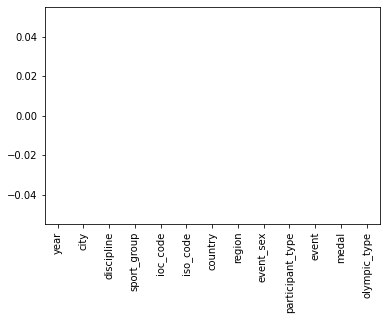

In [66]:
for ds in tables:
   df = con.execute(f'SELECT * FROM {ds}').df()
   df.isna().sum().plot(kind='bar')


### Missing values function

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

def missing_values(df):


  df = df.replace({None: np.nan})
  #select categorical and numerical features
  numerical_features = df.select_dtypes("number")
  categorical_features = df.select_dtypes("object")

  # scaler = MinMaxScaler(feature_range=(0,1))

  # creating the pipline for numerical values
  numeric_transformer = Pipeline(
     # steps=[("scaler", scaler), ("imputer", KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'))]
      steps=[("imputer", KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean'))]
  )

  # creating the pipline for categorical values
  categorical_transformer = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
  #categorical_transformer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

  # Preprocessor
  preprocessor = ColumnTransformer(
      transformers=[
          ("cat", categorical_transformer, categorical_features.columns),
          ("num", numeric_transformer, numerical_features.columns),
      ]
  )


  # use the pipline
  pipline_result = preprocessor.fit_transform(df)

  #transform the numpy result into the original dataframe
  # pipline_result = scaler.inverse_transform(pipline_result)

  #TODO: SOLVE that return values are scaled  
  pipline_result = pd.DataFrame(pipline_result, columns=df.columns)

  #result = {"result", pipline_result, "preprocessor", preprocessor}

  return pipline_result


### Apply the function 

In [ ]:
for ds in tables:
  # table as dataframe
  df = con.execute(f'SELECT * FROM {ds}').df()
  # apply function
  df = missing_values(df)
  # replace table with new imputed one
  con.execute(f'DROP TABLE IF EXISTS {ds};')
  con.execute(f'CREATE TABLE IF NOT EXISTS {ds} AS SELECT * FROM df;')



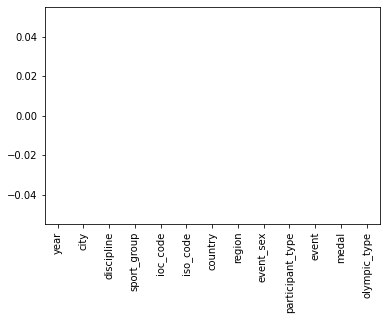

In [67]:
for ds in tables:
   df = con.execute(f'SELECT * FROM {ds}').df()
   df.isna().sum().plot(kind='bar')

### Save the results

In [ ]:
con.execute("SHOW TABLES").fetchall()

[('Country_Level_Data',), ('Governance_Data',), ('Olympics_Data',)]

In [ ]:
con.close()